# **DDoS Model Evaluation Summary**
---

## **Imports and Configuration**
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import warnings

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras.models import model_from_json

In [2]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [3]:
# Data, encoders and normalizer paths
dataset_name = '75-20-05-udplag.syn'

input_path = os.path.join('data/clean', dataset_name)
encoders_path = os.path.join(input_path, 'encoders')
stats_path = os.path.join(input_path, 'stats')
data_path = os.path.join(input_path, 'split-sets-balanced-smote')

# Model paths settings
model_types = ['neural-network', 'random-forest', 'decision-tree', 'knn', 'gradient-boost']
model_paths = [os.path.join('models', 'layer-0', model_type) for model_type in model_types]

## **Load Validation and Test Datasets**
---

In [4]:
# Load Data
X_val = pd.read_csv(os.path.join(data_path, 'X_val.csv'))
y_val = pd.read_csv(os.path.join(data_path, 'y_val.csv'))
X_test = pd.read_csv(os.path.join(data_path, 'X_test.csv'))
y_test = pd.read_csv(os.path.join(data_path, 'y_test.csv'))

## **Load Encoders and Normalizing Stats**
---

In [5]:
# Load label encoder
with open(os.path.join(encoders_path, 'label-encoder.pkl'), 'rb') as file:
    label_encoder = pickle.load(file)

# Load one-hot encoder
with open(os.path.join(encoders_path, 'onehot-encoder.pkl'), 'rb') as file:
    onehot_encoder = pickle.load(file)
    
# Load standard scaler
with open(os.path.join(stats_path, 'standard-scaler.pkl'), 'rb') as file:
    standard_scaler = pickle.load(file)

## **Normalize and Transform Validation Data**
---

In [6]:
# Standard normalization of X
X_val = standard_scaler.transform(X_val)
X_test = standard_scaler.transform(X_test)

# One-hot encoding of y
y_val_onehot = onehot_encoder.transform(y_val)
y_test_onehot = onehot_encoder.transform(y_test)

# Label encoding of y
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [7]:
print(f'         X_val.shape = {X_val.shape}')
print(f'         y_val.shape = {y_val.shape}')
print(f'  y_val_onehot.shape = {y_val_onehot.shape}\n')

print(f'        X_test.shape = {X_test.shape}')
print(f'        y_test.shape = {y_test.shape}')
print(f' y_test_onehot.shape = {y_test_onehot.shape}')

         X_val.shape = (1770568, 78)
         y_val.shape = (1770568,)
  y_val_onehot.shape = (1770568, 9)

        X_test.shape = (442643, 78)
        y_test.shape = (442643,)
 y_test_onehot.shape = (442643, 9)


## **Load Models**
---

### ***Neural Network***

In [8]:
# Define normalize method name
normalize_name = 'standard-v4'

# Load model architecture
with open(os.path.join(model_paths[0], f'model-nn-{normalize_name}.architecture.json'), 'r') as file:
    model_nn = model_from_json(file.read())

# Load weights
model_nn.load_weights(os.path.join(model_paths[0], f'model-nn-{normalize_name}.weights.h5'))

# Check model summary
model_nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          10,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 538,013 (2.05 MB)

 Trainable params: 179,337 (700.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 358,676 (1.37 MB)

### ***Random Forest***

In [9]:
# Define normalize method name
normalize_name = 'standard-v2'

# Load model
with open(os.path.join(model_paths[1], f'model-rf-{normalize_name}.object.pkl'), 'rb') as file:
    model_rf = pickle.load(file)

# Show model summary
model_rf

RandomForestClassifier(n_jobs=-1, verbose=3)

### ***Decision Tree***

In [10]:
# Define normalize method name
normalize_name = 'standard-v2'

# Load model
with open(os.path.join(model_paths[2], f'model-dt-{normalize_name}.object.pkl'), 'rb') as file:
    model_dt = pickle.load(file)

# Show model summary
model_dt

DecisionTreeClassifier()

### ***KNN***

In [11]:
# Define normalize method name
normalize_name = 'standard-v2'

# Load model
with open(os.path.join(model_paths[3], f'model-kn-{normalize_name}.object.pkl'), 'rb') as file:
    model_kn = pickle.load(file)

# Show model summary
model_kn

KNeighborsClassifier(n_jobs=-1)

### ***Gradient Boosting***

In [12]:
# Define normalize method name
normalize_name = 'standard-v2'

# Load model
with open(os.path.join(model_paths[4], f'model-gb-{normalize_name}.object.pkl'), 'rb') as file:
    model_gb = pickle.load(file)

# Show model summary
model_gb

HistGradientBoostingClassifier(verbose=1)

## **Models Evaluation**
---

### ***Neural Network***

In [13]:
y_prob_nn_val = model_nn.predict(X_val)
y_pred_nn_val = np.argmax(y_prob_nn_val, axis=1)

55331/55331 ━━━━━━━━━━━━━━━━━━━━ 93s 2ms/step 


In [14]:
print(f'Metrics for validation:\n')
print(f'Accuracy = {accuracy_score(y_val, y_pred_nn_val)}\n')
print(classification_report(y_val, y_pred_nn_val, target_names=list(label_encoder.classes_)))

Metrics for validation:

Accuracy = 0.8967416106017956

                 precision    recall  f1-score   support

         BENIGN       0.93      1.00      0.96     11556
       DNS/LDAP       0.82      0.76      0.79    164076
          MSSQL       0.91      0.93      0.92    193900
            NTP       0.98      0.99      0.99    195493
NetBIOS/Portmap       0.83      0.96      0.89    235471
           SNMP       0.74      0.66      0.70    198634
       SSDP/UDP       0.95      0.94      0.94    223022
     Syn/UDPLag       0.93      0.97      0.95    352193
           TFTP       1.00      0.86      0.92    196223

       accuracy                           0.90   1770568
      macro avg       0.90      0.90      0.90   1770568
   weighted avg       0.90      0.90      0.90   1770568



In [15]:
y_prob_nn_test = model_nn.predict(X_test)
y_pred_nn_test = np.argmax(y_prob_nn_test, axis=1)

13833/13833 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step


In [16]:
print(f'Metrics for test:\n')
print(f'Accuracy = {accuracy_score(y_test, y_pred_nn_test)}\n')
print(classification_report(y_test, y_pred_nn_test, target_names=list(label_encoder.classes_)))

Metrics for test:

Accuracy = 0.8966209789830631

                 precision    recall  f1-score   support

         BENIGN       0.94      1.00      0.97      2827
       DNS/LDAP       0.82      0.76      0.79     40987
          MSSQL       0.91      0.93      0.92     48599
            NTP       0.98      1.00      0.99     48900
NetBIOS/Portmap       0.83      0.96      0.89     58680
           SNMP       0.74      0.66      0.70     49756
       SSDP/UDP       0.95      0.94      0.95     56214
     Syn/UDPLag       0.93      0.97      0.95     87766
           TFTP       1.00      0.86      0.93     48914

       accuracy                           0.90    442643
      macro avg       0.90      0.90      0.90    442643
   weighted avg       0.90      0.90      0.90    442643



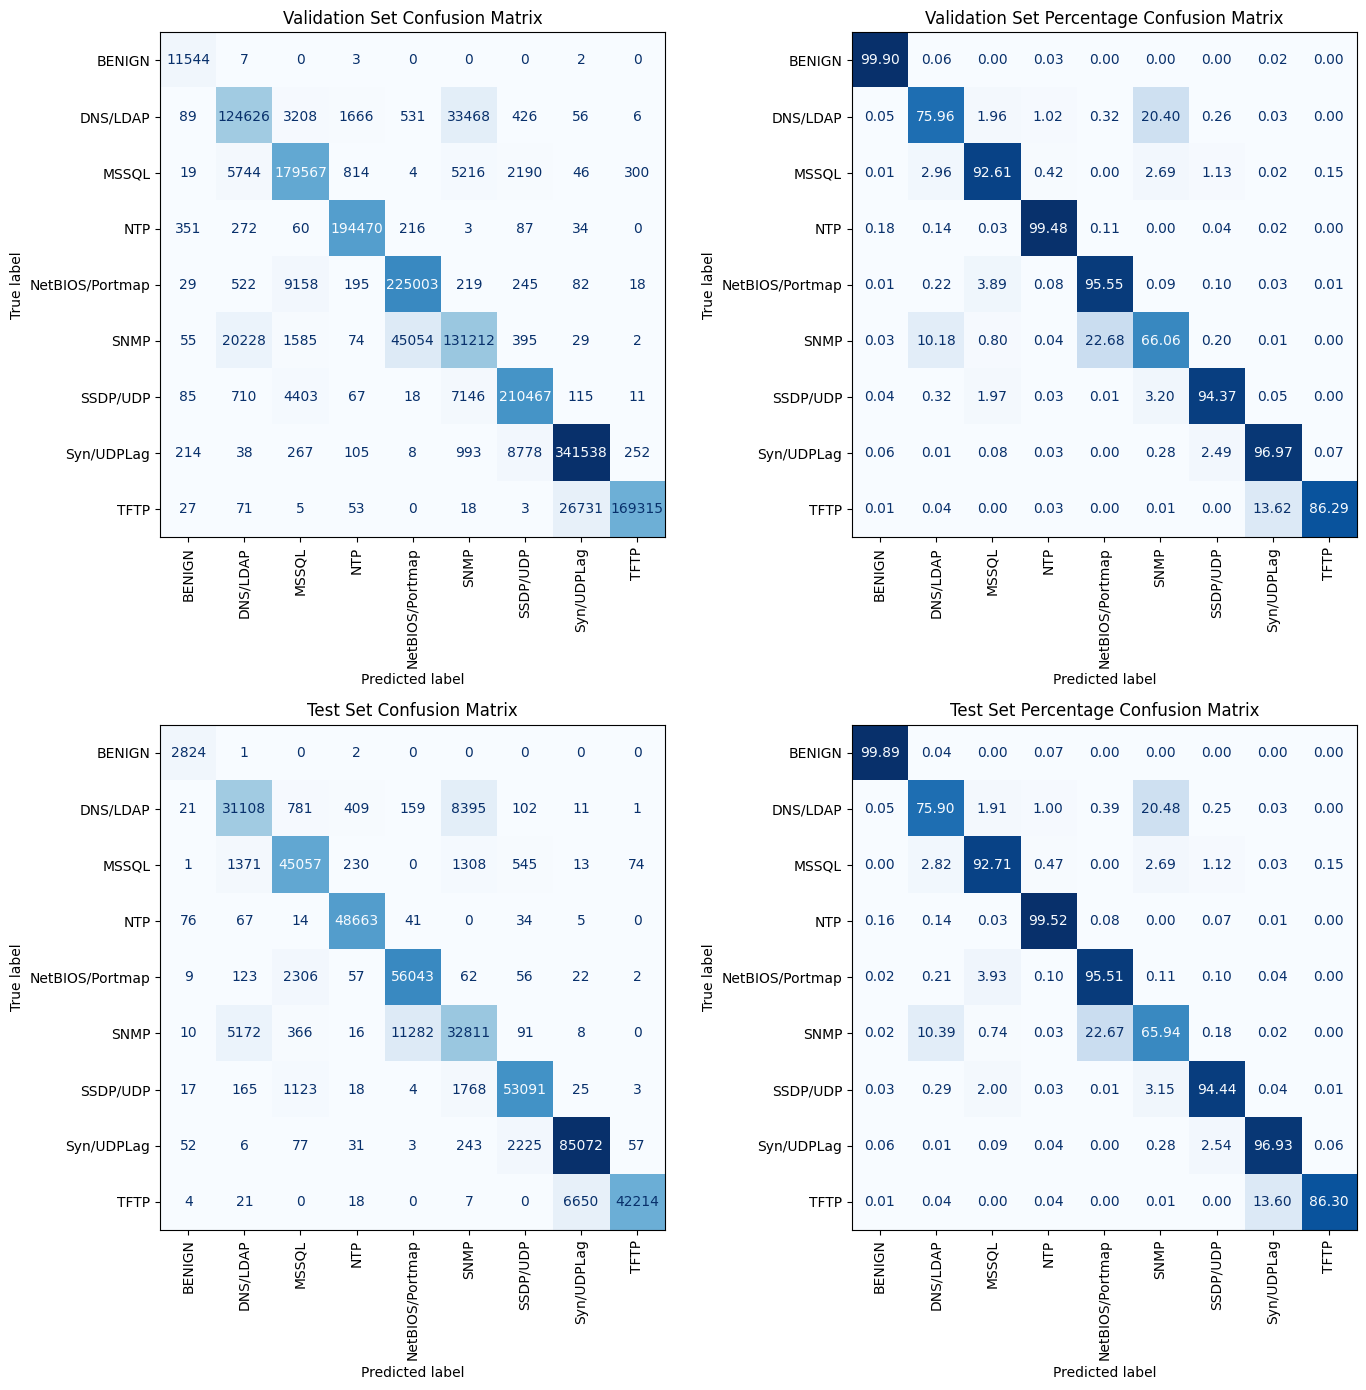

In [17]:
# Compute confusion matrices
conf_matrix_val = confusion_matrix(y_val, y_pred_nn_val)
conf_matrix_test = confusion_matrix(y_test, y_pred_nn_test)

conf_matrix_val_percentage = conf_matrix_val.astype('float') / conf_matrix_val.sum(axis=1, keepdims=True) * 100
conf_matrix_test_percentage = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1, keepdims=True) * 100

# Confusion matrices, plot titles and formats
conf_matrices = [
    conf_matrix_val,
    conf_matrix_val_percentage,
    conf_matrix_test,
    conf_matrix_test_percentage
]

titles = [
    'Validation Set Confusion Matrix',
    'Validation Set Percentage Confusion Matrix',
    'Test Set Confusion Matrix',
    'Test Set Percentage Confusion Matrix'
]

formats = ['d', '.2f', 'd', '.2f']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Plot confusion matrices
for ax, conf_matrix, title, format_ in zip(axes.reshape(-1,), conf_matrices, titles, formats):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(label_encoder.classes_))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation='vertical', values_format=format_)
    ax.set_title(title)

plt.tight_layout()
plt.show()

### ***Random Forest***

In [18]:
y_pred_rf_val = model_rf.predict(X_val)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  71 out of 100 | elapsed:    6.4s remaining:    2.5s
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    7.9s finished


In [19]:
print(f'Metrics for validation:\n')
print(f'Accuracy = {accuracy_score(y_val, y_pred_rf_val)}\n')
print(classification_report(y_val, y_pred_rf_val, target_names=list(label_encoder.classes_)))

Metrics for validation:

Accuracy = 0.912052516480587

                 precision    recall  f1-score   support

         BENIGN       0.99      1.00      1.00     11556
       DNS/LDAP       0.83      0.82      0.83    164076
          MSSQL       0.93      0.94      0.93    193900
            NTP       0.99      1.00      1.00    195493
NetBIOS/Portmap       0.93      0.88      0.90    235471
           SNMP       0.75      0.81      0.78    198634
       SSDP/UDP       0.95      0.95      0.95    223022
     Syn/UDPLag       0.93      0.96      0.94    352193
           TFTP       0.98      0.87      0.92    196223

       accuracy                           0.91   1770568
      macro avg       0.92      0.92      0.92   1770568
   weighted avg       0.91      0.91      0.91   1770568



In [20]:
y_pred_rf_test = model_rf.predict(X_test)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  71 out of 100 | elapsed:    1.5s remaining:    0.5s
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    1.7s finished


In [21]:
print(f'Metrics for test:\n')
print(f'Accuracy = {accuracy_score(y_test, y_pred_rf_test)}\n')
print(classification_report(y_test, y_pred_rf_test, target_names=list(label_encoder.classes_)))

Metrics for test:

Accuracy = 0.9116014485714221

                 precision    recall  f1-score   support

         BENIGN       0.99      1.00      0.99      2827
       DNS/LDAP       0.83      0.82      0.83     40987
          MSSQL       0.93      0.94      0.93     48599
            NTP       0.99      1.00      1.00     48900
NetBIOS/Portmap       0.93      0.88      0.90     58680
           SNMP       0.75      0.81      0.78     49756
       SSDP/UDP       0.95      0.95      0.95     56214
     Syn/UDPLag       0.93      0.96      0.94     87766
           TFTP       0.98      0.88      0.92     48914

       accuracy                           0.91    442643
      macro avg       0.92      0.91      0.92    442643
   weighted avg       0.91      0.91      0.91    442643



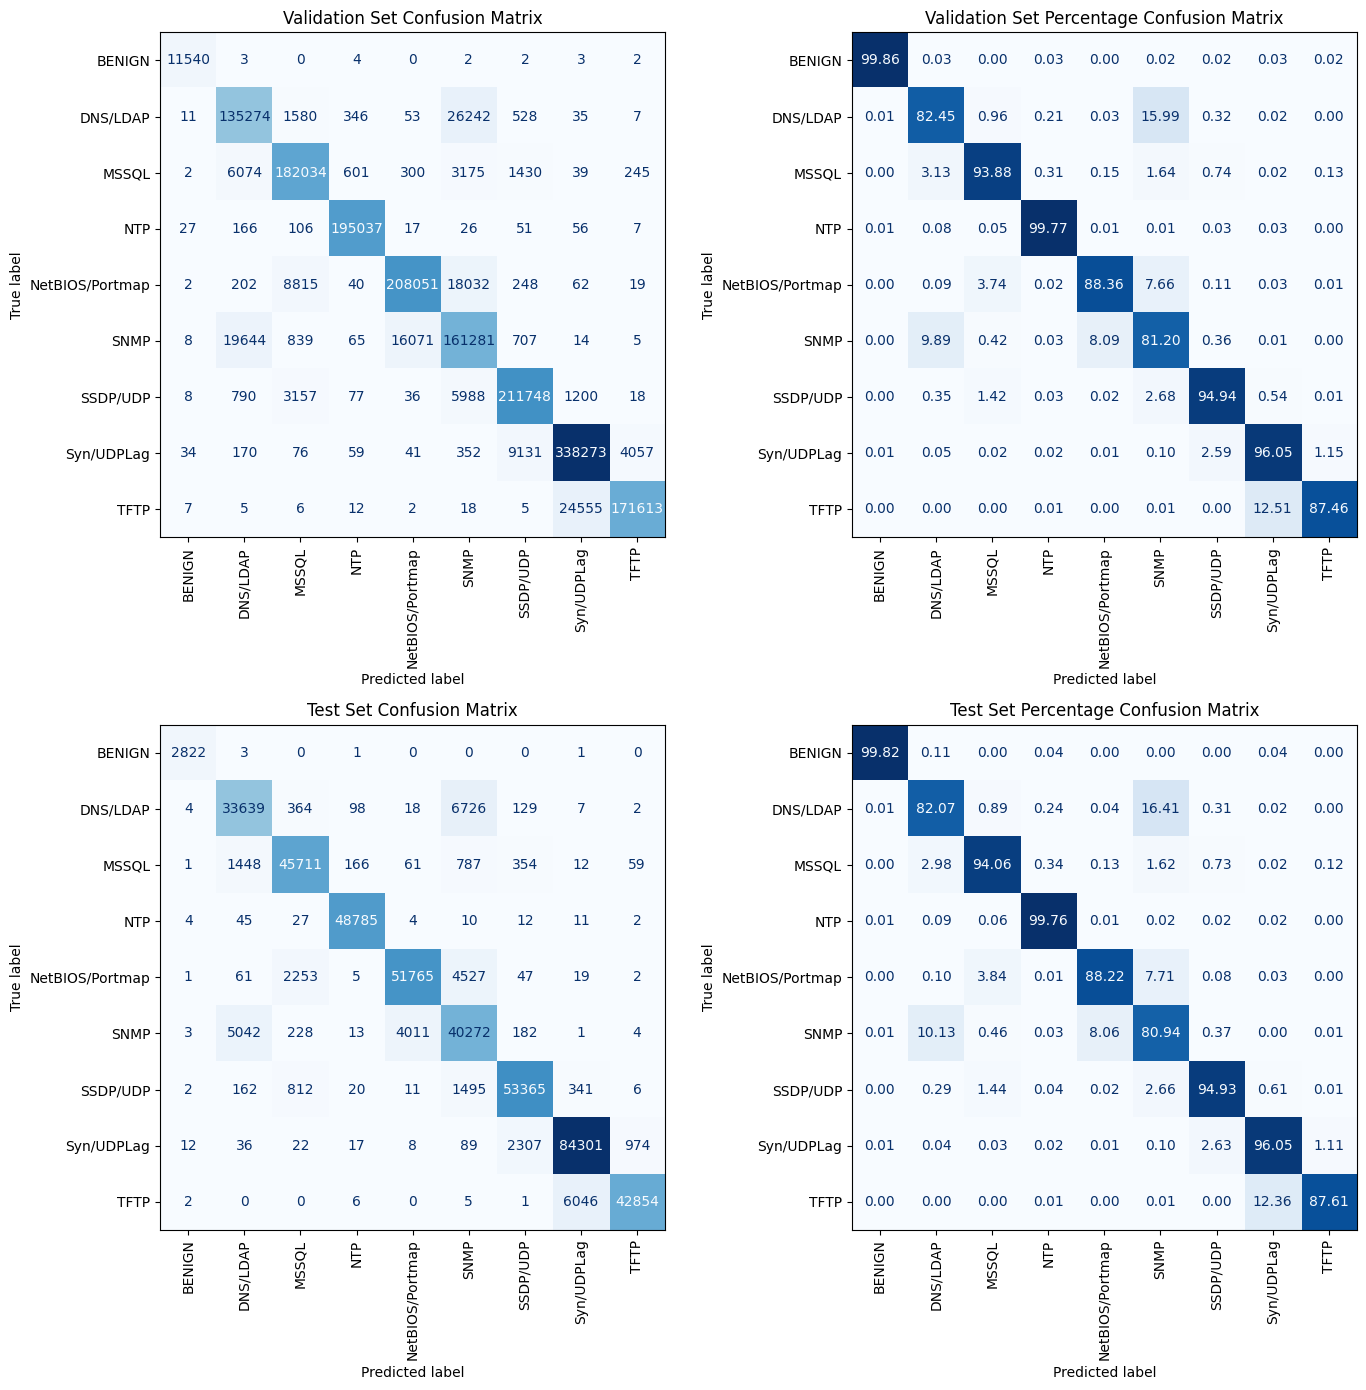

In [22]:
# Compute confusion matrices
conf_matrix_val = confusion_matrix(y_val, y_pred_rf_val)
conf_matrix_test = confusion_matrix(y_test, y_pred_rf_test)

conf_matrix_val_percentage = conf_matrix_val.astype('float') / conf_matrix_val.sum(axis=1, keepdims=True) * 100
conf_matrix_test_percentage = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1, keepdims=True) * 100

# Confusion matrices, plot titles and formats
conf_matrices = [
    conf_matrix_val,
    conf_matrix_val_percentage,
    conf_matrix_test,
    conf_matrix_test_percentage
]

titles = [
    'Validation Set Confusion Matrix',
    'Validation Set Percentage Confusion Matrix',
    'Test Set Confusion Matrix',
    'Test Set Percentage Confusion Matrix'
]

formats = ['d', '.2f', 'd', '.2f']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Plot confusion matrices
for ax, conf_matrix, title, format_ in zip(axes.reshape(-1,), conf_matrices, titles, formats):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(label_encoder.classes_))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation='vertical', values_format=format_)
    ax.set_title(title)

plt.tight_layout()
plt.show()

### ***Decision Tree***

In [23]:
y_pred_dt_val = model_dt.predict(X_val)

In [24]:
print(f'Metrics for validation:\n')
print(f'Accuracy = {accuracy_score(y_val, y_pred_dt_val)}\n')
print(classification_report(y_val, y_pred_dt_val, target_names=list(label_encoder.classes_)))

Metrics for validation:

Accuracy = 0.910865891623479

                 precision    recall  f1-score   support

         BENIGN       0.99      1.00      1.00     11556
       DNS/LDAP       0.83      0.82      0.83    164076
          MSSQL       0.93      0.94      0.93    193900
            NTP       0.99      1.00      1.00    195493
NetBIOS/Portmap       0.93      0.88      0.90    235471
           SNMP       0.75      0.81      0.78    198634
       SSDP/UDP       0.95      0.94      0.94    223022
     Syn/UDPLag       0.92      0.96      0.94    352193
           TFTP       0.98      0.87      0.92    196223

       accuracy                           0.91   1770568
      macro avg       0.92      0.91      0.92   1770568
   weighted avg       0.91      0.91      0.91   1770568



In [25]:
y_pred_dt_test = model_dt.predict(X_test)

In [26]:
print(f'Metrics for test:\n')
print(f'Accuracy = {accuracy_score(y_test, y_pred_dt_test)}\n')
print(classification_report(y_test, y_pred_dt_test, target_names=list(label_encoder.classes_)))

Metrics for test:

Accuracy = 0.9104244278120291

                 precision    recall  f1-score   support

         BENIGN       0.99      1.00      1.00      2827
       DNS/LDAP       0.83      0.82      0.83     40987
          MSSQL       0.93      0.94      0.93     48599
            NTP       0.99      1.00      1.00     48900
NetBIOS/Portmap       0.93      0.88      0.90     58680
           SNMP       0.75      0.81      0.78     49756
       SSDP/UDP       0.95      0.94      0.94     56214
     Syn/UDPLag       0.92      0.96      0.94     87766
           TFTP       0.98      0.88      0.92     48914

       accuracy                           0.91    442643
      macro avg       0.92      0.91      0.92    442643
   weighted avg       0.91      0.91      0.91    442643



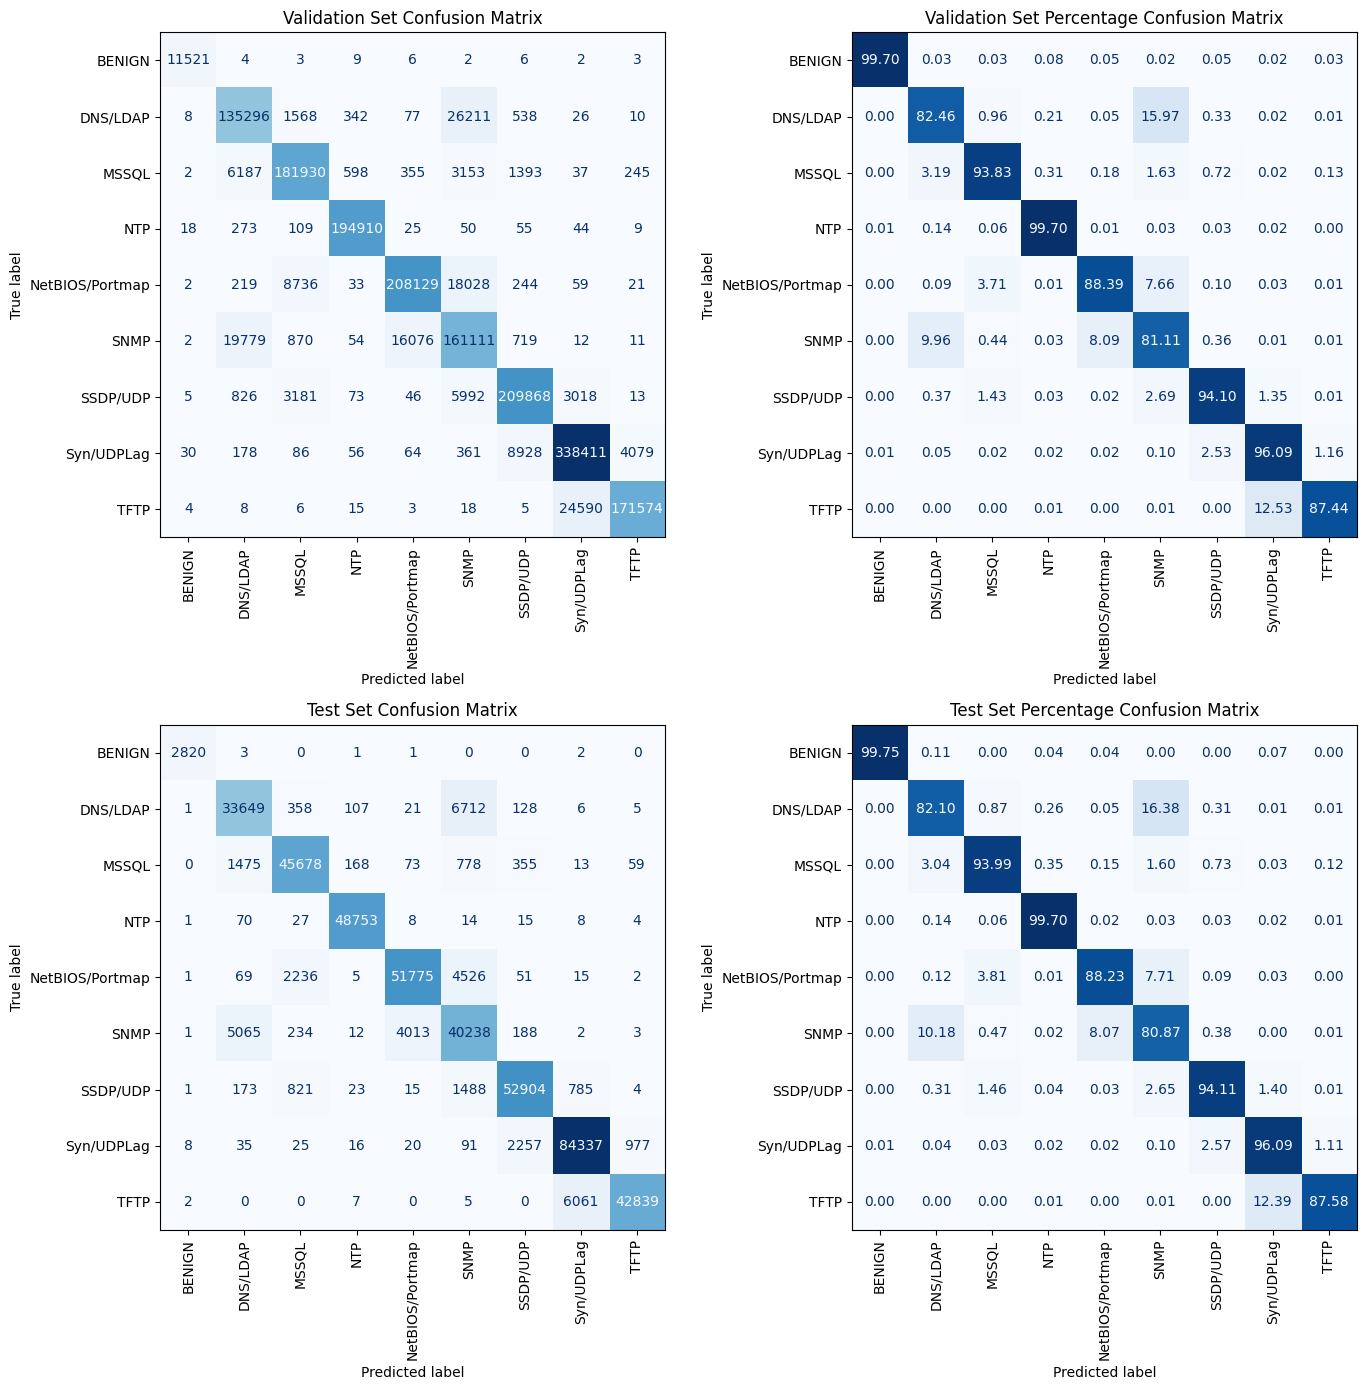

In [27]:
# Compute confusion matrices
conf_matrix_val = confusion_matrix(y_val, y_pred_dt_val)
conf_matrix_test = confusion_matrix(y_test, y_pred_dt_test)

conf_matrix_val_percentage = conf_matrix_val.astype('float') / conf_matrix_val.sum(axis=1, keepdims=True) * 100
conf_matrix_test_percentage = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1, keepdims=True) * 100

# Confusion matrices, plot titles and formats
conf_matrices = [
    conf_matrix_val,
    conf_matrix_val_percentage,
    conf_matrix_test,
    conf_matrix_test_percentage
]

titles = [
    'Validation Set Confusion Matrix',
    'Validation Set Percentage Confusion Matrix',
    'Test Set Confusion Matrix',
    'Test Set Percentage Confusion Matrix'
]

formats = ['d', '.2f', 'd', '.2f']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Plot confusion matrices
for ax, conf_matrix, title, format_ in zip(axes.reshape(-1,), conf_matrices, titles, formats):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(label_encoder.classes_))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation='vertical', values_format=format_)
    ax.set_title(title)

plt.tight_layout()
plt.show()

### ***KNN***

In [28]:
y_pred_kn_val = model_kn.predict(X_val)

In [29]:
print(f'Metrics for validation:\n')
print(f'Accuracy = {accuracy_score(y_val, y_pred_kn_val)}\n')
print(classification_report(y_val, y_pred_kn_val, target_names=list(label_encoder.classes_)))

Metrics for validation:

Accuracy = 0.9030299881168077

                 precision    recall  f1-score   support

         BENIGN       0.98      1.00      0.99     11556
       DNS/LDAP       0.77      0.84      0.80    164076
          MSSQL       0.92      0.94      0.93    193900
            NTP       0.99      1.00      0.99    195493
NetBIOS/Portmap       0.90      0.90      0.90    235471
           SNMP       0.75      0.71      0.73    198634
       SSDP/UDP       0.94      0.95      0.95    223022
     Syn/UDPLag       0.93      0.96      0.94    352193
           TFTP       0.97      0.87      0.92    196223

       accuracy                           0.90   1770568
      macro avg       0.91      0.91      0.91   1770568
   weighted avg       0.90      0.90      0.90   1770568



In [30]:
y_pred_kn_test = model_kn.predict(X_test)

In [31]:
print(f'Metrics for test:\n')
print(f'Accuracy = {accuracy_score(y_test, y_pred_kn_test)}\n')
print(classification_report(y_test, y_pred_kn_test, target_names=list(label_encoder.classes_)))

Metrics for test:

Accuracy = 0.9028359196914896

                 precision    recall  f1-score   support

         BENIGN       0.98      1.00      0.99      2827
       DNS/LDAP       0.77      0.84      0.80     40987
          MSSQL       0.92      0.94      0.93     48599
            NTP       0.99      1.00      0.99     48900
NetBIOS/Portmap       0.90      0.90      0.90     58680
           SNMP       0.75      0.71      0.73     49756
       SSDP/UDP       0.94      0.95      0.95     56214
     Syn/UDPLag       0.93      0.96      0.94     87766
           TFTP       0.97      0.88      0.92     48914

       accuracy                           0.90    442643
      macro avg       0.91      0.91      0.91    442643
   weighted avg       0.90      0.90      0.90    442643



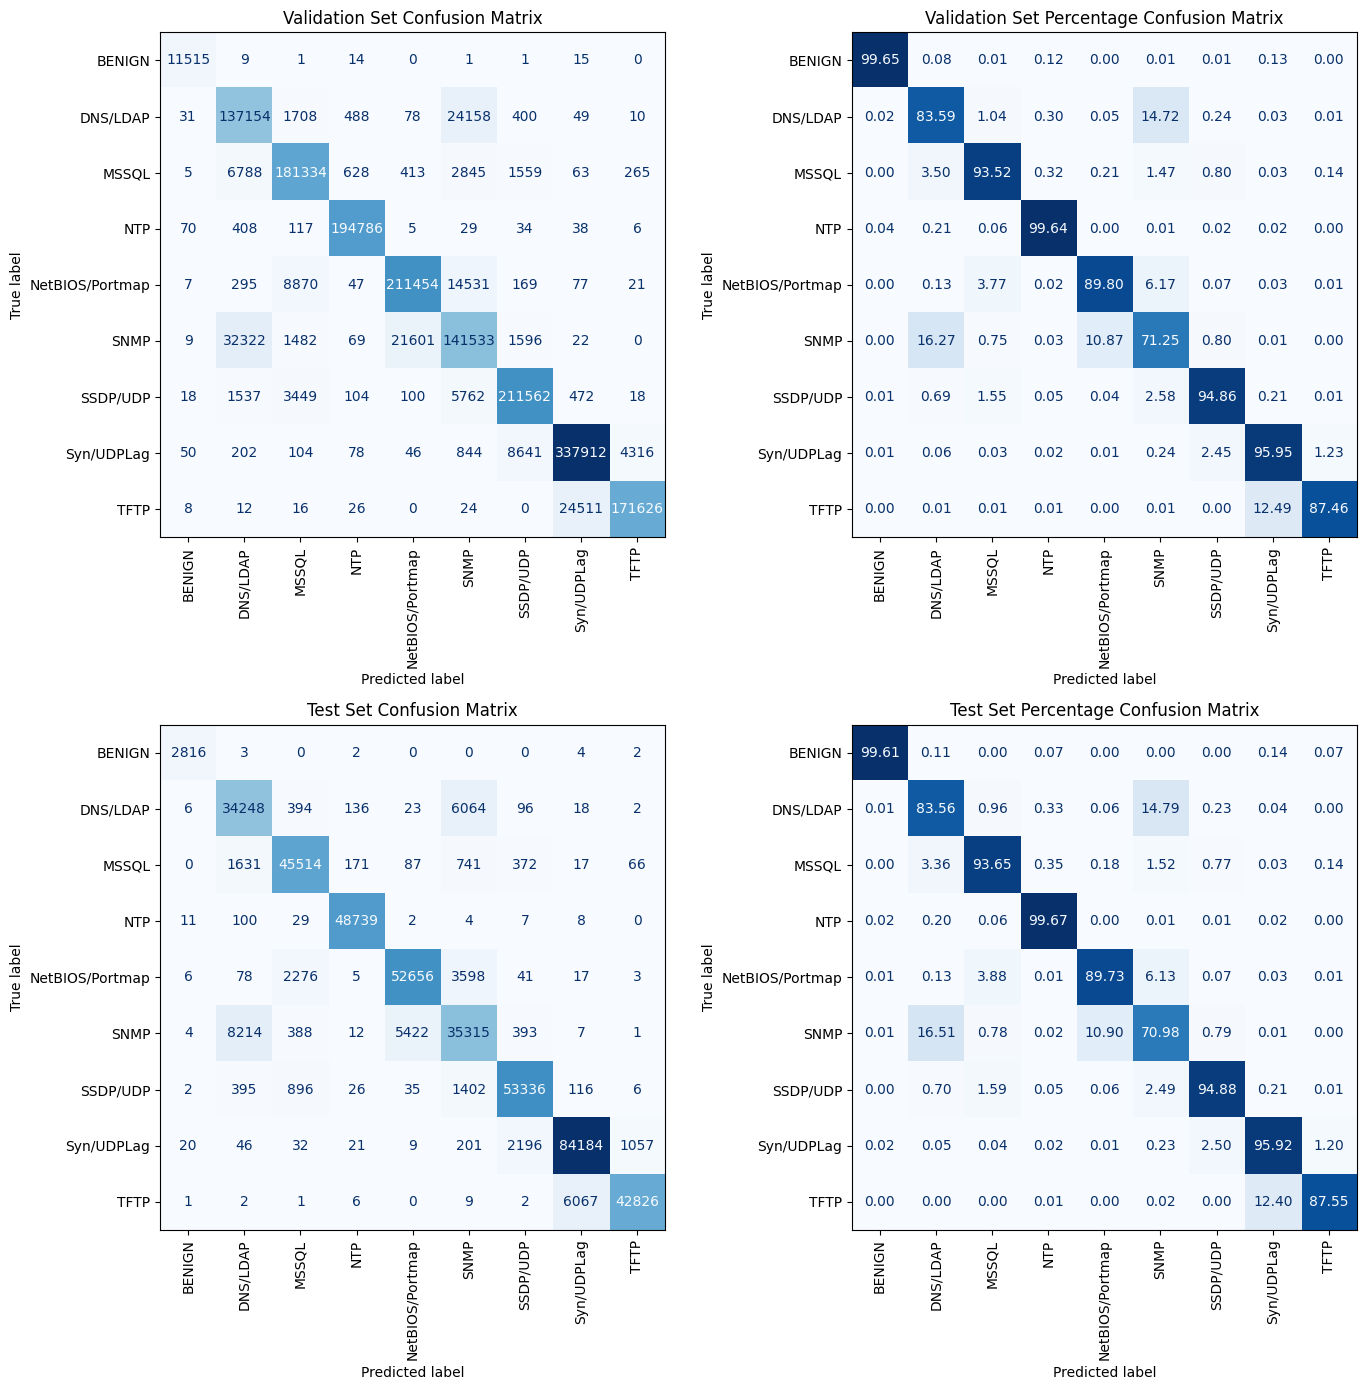

In [32]:
# Compute confusion matrices
conf_matrix_val = confusion_matrix(y_val, y_pred_kn_val)
conf_matrix_test = confusion_matrix(y_test, y_pred_kn_test)

conf_matrix_val_percentage = conf_matrix_val.astype('float') / conf_matrix_val.sum(axis=1, keepdims=True) * 100
conf_matrix_test_percentage = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1, keepdims=True) * 100

# Confusion matrices, plot titles and formats
conf_matrices = [
    conf_matrix_val,
    conf_matrix_val_percentage,
    conf_matrix_test,
    conf_matrix_test_percentage
]

titles = [
    'Validation Set Confusion Matrix',
    'Validation Set Percentage Confusion Matrix',
    'Test Set Confusion Matrix',
    'Test Set Percentage Confusion Matrix'
]

formats = ['d', '.2f', 'd', '.2f']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Plot confusion matrices
for ax, conf_matrix, title, format_ in zip(axes.reshape(-1,), conf_matrices, titles, formats):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(label_encoder.classes_))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation='vertical', values_format=format_)
    ax.set_title(title)

plt.tight_layout()
plt.show()

### ***Gradient Boosting***

In [33]:
y_pred_gb_val = model_gb.predict(X_val)

In [34]:
print(f'Metrics for validation:\n')
print(f'Accuracy = {accuracy_score(y_val, y_pred_gb_val)}\n')
print(classification_report(y_val, y_pred_gb_val, target_names=list(label_encoder.classes_)))

Metrics for validation:

Accuracy = 0.9084322093249172

                 precision    recall  f1-score   support

         BENIGN       0.97      1.00      0.98     11556
       DNS/LDAP       0.82      0.80      0.81    164076
          MSSQL       0.92      0.93      0.92    193900
            NTP       0.99      1.00      0.99    195493
NetBIOS/Portmap       0.93      0.88      0.90    235471
           SNMP       0.73      0.81      0.77    198634
       SSDP/UDP       0.95      0.95      0.95    223022
     Syn/UDPLag       0.93      0.97      0.95    352193
           TFTP       0.99      0.87      0.92    196223

       accuracy                           0.91   1770568
      macro avg       0.91      0.91      0.91   1770568
   weighted avg       0.91      0.91      0.91   1770568



In [35]:
y_pred_gb_test = model_gb.predict(X_test)

In [36]:
print(f'Metrics for test:\n')
print(f'Accuracy = {accuracy_score(y_test, y_pred_gb_test)}\n')
print(classification_report(y_test, y_pred_gb_test, target_names=list(label_encoder.classes_)))

Metrics for test:

Accuracy = 0.9080477947239649

                 precision    recall  f1-score   support

         BENIGN       0.97      1.00      0.99      2827
       DNS/LDAP       0.82      0.80      0.81     40987
          MSSQL       0.92      0.93      0.92     48599
            NTP       0.99      1.00      0.99     48900
NetBIOS/Portmap       0.93      0.88      0.90     58680
           SNMP       0.73      0.81      0.77     49756
       SSDP/UDP       0.95      0.95      0.95     56214
     Syn/UDPLag       0.93      0.97      0.95     87766
           TFTP       0.99      0.87      0.92     48914

       accuracy                           0.91    442643
      macro avg       0.91      0.91      0.91    442643
   weighted avg       0.91      0.91      0.91    442643



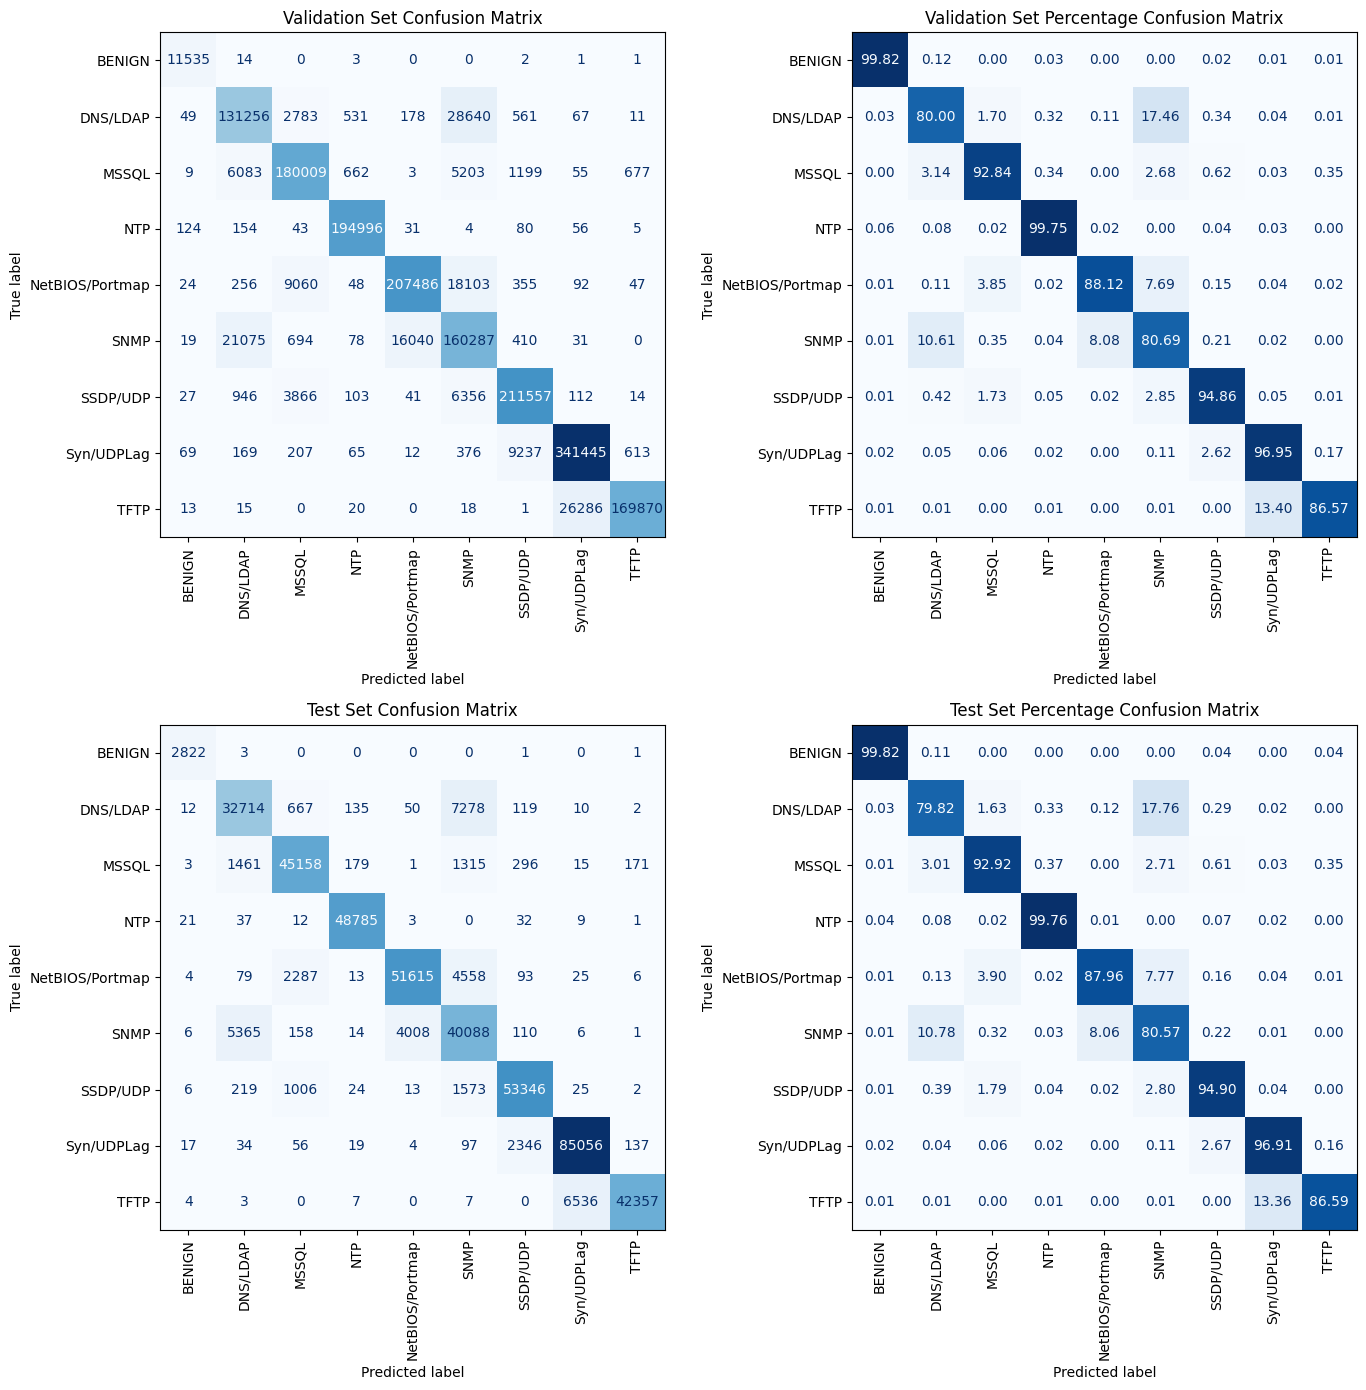

In [37]:
# Compute confusion matrices
conf_matrix_val = confusion_matrix(y_val, y_pred_gb_val)
conf_matrix_test = confusion_matrix(y_test, y_pred_gb_test)

conf_matrix_val_percentage = conf_matrix_val.astype('float') / conf_matrix_val.sum(axis=1, keepdims=True) * 100
conf_matrix_test_percentage = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1, keepdims=True) * 100

# Confusion matrices, plot titles and formats
conf_matrices = [
    conf_matrix_val,
    conf_matrix_val_percentage,
    conf_matrix_test,
    conf_matrix_test_percentage
]

titles = [
    'Validation Set Confusion Matrix',
    'Validation Set Percentage Confusion Matrix',
    'Test Set Confusion Matrix',
    'Test Set Percentage Confusion Matrix'
]

formats = ['d', '.2f', 'd', '.2f']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Plot confusion matrices
for ax, conf_matrix, title, format_ in zip(axes.reshape(-1,), conf_matrices, titles, formats):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(label_encoder.classes_))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation='vertical', values_format=format_)
    ax.set_title(title)

plt.tight_layout()
plt.show()